# Item Response Theory with Expectation Maximization Optimization (EMIRT)

This notebook will show you how to train and use the EMIRT.
First, we will show how to get the data (here we use a0910 as the dataset).
Then we will show how to train a EMIRT and perform the parameters persistence.
At last, we will show how to load the parameters from the file and evaluate on the test dataset.

The script version could be found in [IRT.py](IRT.py)

In [10]:
# Load the data from files
import pandas as pd

train_data = pd.read_csv("../../../data/a0910/train.csv")
valid_data = pd.read_csv("../../../data/a0910/valid.csv")
test_data = pd.read_csv("../../../data/a0910/test.csv")

train_data.head(5)

,user_id,item_id,score
0,1615,12977,1
1,782,13124,0
2,1084,16475,0
3,593,8690,0
4,127,14225,1


<AxesSubplot: xlabel='user_id', ylabel='Count'>

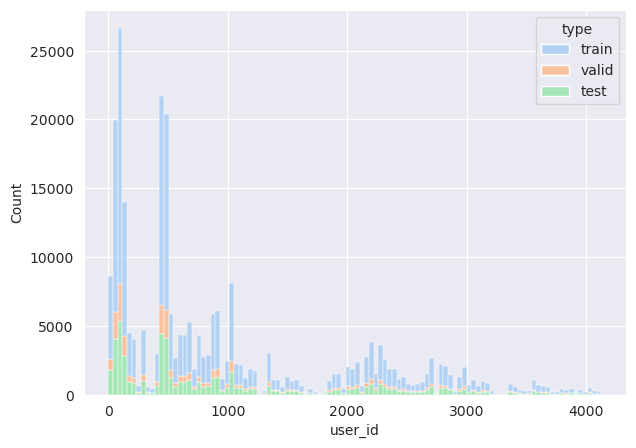

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
f = plt.figure(figsize=(7,5))
ax = f.add_subplot(1,1,1)
train_data['type'] = ['train']*len(train_data.index)
valid_data['type'] = ['valid']*len(valid_data.index)
test_data['type'] = ['test']*len(test_data.index)
frames = [train_data, valid_data, test_data]

# Just one adaptable dataset
dataset = pd.concat(frames)

sns.histplot(data=dataset, ax=ax, stat="count", multiple="stack",
             x="user_id", kde=False,
             palette="pastel", hue="type",
             element="bars", legend=True)


<AxesSubplot: xlabel='item_id', ylabel='Count'>

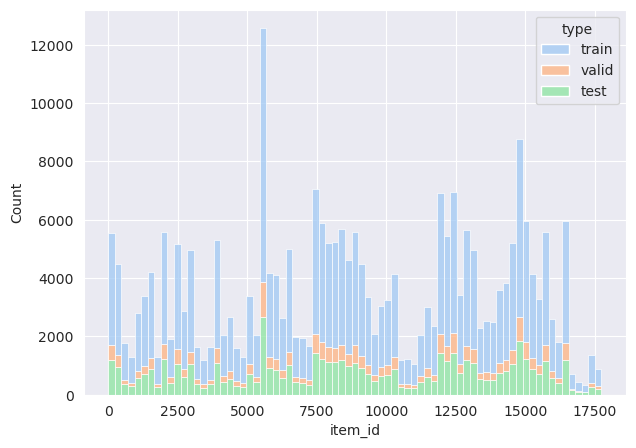

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
f = plt.figure(figsize=(7,5))
ax = f.add_subplot(1,1,1)

sns.histplot(data=dataset, ax=ax, stat="count", multiple="stack",
             x="item_id", kde=False,
             palette="pastel", hue="type",
             element="bars", legend=True)

In [12]:
import numpy as np
# Dans le découpage original, tous les dataset contiennent tous les utilisateurs :
print(len(train_data['user_id'].unique()))
print(len(test_data['user_id'].unique()))
print(len(valid_data['user_id'].unique()))
print(np.average(train_data['user_id'].unique()))
print(np.average(test_data['user_id'].unique()))
print(np.average(valid_data['user_id'].unique()))

# Les items balayés par chaque dataset varient
print("---Items :")
print(len(train_data['item_id'].unique()))
print(len(test_data['item_id'].unique()))
print(len(valid_data['item_id'].unique()))

2493
2493
2493
1752.2109907741676
1752.2109907741676
1752.2109907741676
---Items :
17051
13682
10415


In [10]:
import numpy as np
test_data[test_data['user_id']==127]

,user_id,item_id,score
4,127,14225,1
20,127,677,0
156,127,3979,0
319,127,15808,1
2406,127,3281,1
...,...,...,...
183870,127,13468,1
183968,127,2767,1
185013,127,2466,1
185476,127,15310,0


In [11]:
len(train_data), len(valid_data), len(test_data)

(55760, 25606, 186049)

In [12]:
# nb d'étudiants
stu_num = max(max(train_data['user_id']), max(test_data['user_id']))

# nb d'items / de problèmes
prob_num = max(max(train_data['item_id']), max(test_data['item_id']))
print(stu_num, prob_num)

4128 17746


In [13]:
import numpy as np

# construction d'une matrice des scores du training set
R = -1 * np.ones(shape=(stu_num, prob_num))
R[train_data['user_id']-1, train_data['item_id']-1] = train_data['score']

# construction d'une liste des données du test set
test_set = []
for i in range(len(test_data)):
    row = test_data.iloc[i]
    test_set.append({'user_id':int(row['user_id'])-1, 'item_id':int(row['item_id'])-1, 'score':row['score']})

## Training and Persistence

In [14]:
import logging
import importlib

logging.getLogger().setLevel(logging.INFO)

#This module defines functions and classes which implement a flexible event logging system for applications and libraries.

In [15]:
import EduCDM
importlib.reload(EduCDM)
from EduCDM import EMIRT

cdm = EMIRT(R, stu_num, prob_num, dim=1, skip_value=-1) # Attention, ici dim =1 !!

cdm.train(lr=1e-3, epoch=2)
cdm.save("irt.params")

Test de modification du codd ?


INFO:root:save parameters to irt.params


## Loading and Testing

In [16]:
cdm.load("irt.params")
rmse, mae = cdm.eval(test_set)
print("RMSE, MAE are %.6f, %.6f" % (rmse, mae))

INFO:root:load parameters from irt.params
evaluating: 100%|██████████| 186049/186049 [00:00<00:00, 1712599.73it/s]

RMSE, MAE are 0.480522, 0.399553


## Incremental Training

In [14]:
new_data = [{'user_id': 0, 'item_id': 2, 'score': 0.0}, {'user_id': 1, 'item_id': 1, 'score': 1.0}]
cdm.inc_train(new_data, lr=1e-3, epoch=2)

## Evaluate User's State

In [41]:
stu_rec = np.random.randint(-1, 2, size=prob_num)
dia_state = cdm.transform(stu_rec)  # shape = (stu_num, dim)
print("user's state is " + str(dia_state))

user's state is [[-5.18242253]]


# --- Assist dataset exploration ---

In [42]:
import pandas as pd
import numpy as np
import sklearn.preprocessing as skPrep

path = "/home/arthurb/Programmation/NCAT/data/2015_100_skill_builders_main_problems/2015_100_skill_builders_main_problems.csv"
data = pd.read_csv(path, encoding = "ISO-8859-15",low_memory=False)

In [5]:
data.describe()

,user_id,log_id,sequence_id,correct
count,708631.000000,7.086310e+05,708631.000000,708631.000000
mean,296232.978276,1.695323e+08,22683.474821,0.725502
std,48018.650247,3.608096e+06,41593.028018,0.437467
min,50121.000000,1.509145e+08,5898.000000,0.000000
25%,279113.000000,1.660355e+08,7020.000000,0.000000
50%,299168.000000,1.704579e+08,9424.000000,1.000000
75%,335647.000000,1.723789e+08,14442.000000,1.000000
max,362374.000000,1.754827e+08,236309.000000,1.000000


In [64]:
assist2015 = data.rename(columns={'sequence_id':'item_id','correct':'score'})

encoder_dataset = skPrep.OrdinalEncoder()
categorized_data = encoder_dataset.fit_transform(assist2015[['user_id','item_id','score']])
categorized_data = categorized_data.astype(int)
assist2015['user_id'] = categorized_data[:, 0]
assist2015['item_id'] = categorized_data[:, 1]
assist2015['score'] = np.divide(categorized_data[:, 2],10)

In [65]:
nb_users = assist2015['user_id'].max()+1
nb_pb = assist2015['item_id'].max()+1

user_indexes = np.arange(nb_users, dtype=int)
np.random.shuffle(user_indexes)
categorized_training_users, categorized_evaluation_users = np.split(user_indexes, [int(.8 * nb_users - 1)])

categorized_training_data = assist2015[assist2015['user_id'].isin(categorized_training_users)]
categorized_evaluation_data = assist2015[assist2015['user_id'].isin(categorized_evaluation_users)]

In [66]:
# construction d'une matrice des scores du training set
R = -1 * np.ones(shape=(int(nb_users), int(nb_pb)))
R[categorized_training_data['user_id']-1, categorized_training_data['item_id']-1] = categorized_training_data['score']

In [67]:
# construction d'une liste des données du test set
test_set = []
for ind,row in categorized_evaluation_data.iterrows() :
    test_set.append({'user_id':int(row['user_id'])-1, 'item_id':int(row['item_id'])-1, 'score':row['score']})

## Training and Persistence

In [68]:
import logging
import importlib

logging.getLogger().setLevel(logging.INFO)

#This module defines functions and classes which implement a flexible event logging system for applications and libraries.
import EduCDM

importlib.reload(EduCDM)
from EduCDM import EMIRT

cdm = EMIRT(R, nb_users, nb_pb, dim=1, skip_value=-1)  # Attention, ici dim =1 !!

cdm.train(lr=1e-3, epoch=2)
cdm.save("irt.params")

comment ça va ?


INFO:root:save parameters to irt.params


## Loading and Testing

In [69]:
cdm.load("irt.params")
rmse, mae = cdm.eval(test_set)
print("RMSE, MAE are %.6f, %.6f" % (rmse, mae))

INFO:root:load parameters from irt.params
evaluating: 100%|██████████| 142567/142567 [00:00<00:00, 1635435.91it/s]

RMSE, MAE are 0.466005, 0.300957


# --- EMIRT limitations on Assist 2015 datasets ---

## 1. Experiment 1
- horizontal division recquired !!

In [5]:
import pandas as pd
import numpy as np
import sklearn.preprocessing as skPrep
import os

#path = "/home/arthurb/Programmation/NCAT/data/assist-2017/assist-2017.csv"
#path = "/home/arthurb/Programmation/NCAT/data/2015_100_skill_builders_main_problems/2015_100_skill_builders_main_problems.csv"
#dataset = pd.read_csv(path, encoding = "ISO-8859-15",low_memory=False)

#dataset = dataset.rename(columns={'studentId' : 'user_id','problemId' : 'item_id','correct':'score'})
#dataset = dataset.rename(columns={'studentId' : 'user_id','sequence_id' : 'item_id','correct':'score'})
train_data = pd.read_csv("../../../data/a0910/train.csv")
valid_data = pd.read_csv("../../../data/a0910/valid.csv")
test_data = pd.read_csv("../../../data/a0910/test.csv")

dataset_name = "a0910"
experience_num = "9"

exp_path = "/home/arthurb/Programmation/EduCDM/Experiences/"+experience_num

try :
    os.mkdir(exp_path)
except OSError as error:
    print(error)

metadata = "exp_num ="+experience_num+"- dataset : "+dataset_name
print(metadata)

exp_num =9- dataset : a0910


In [6]:
frames = [train_data, valid_data, test_data]

# Just one adaptable dataset
dataset = pd.concat(frames)

metadata +="- merged"

In [7]:
# Cleaning sparse data
T = 20
s = dataset['user_id'].value_counts()
s2 = s[s > (2 * T)]
dataset = dataset[dataset['user_id'].isin(s2.index)]

metadata +="\n- Clean sparse : T ="+str(T)

,user_id,item_id,score


In [11]:
len(dataset['score'].unique())

2

In [9]:
# ----- Re-index elements -----
encoder_dataset = skPrep.OrdinalEncoder()
#categorized_data = encoder_dataset.fit_transform(dataset[['user_id','item_id','score']])
categorized_data = encoder_dataset.fit_transform(dataset[['user_id','item_id']])

dataset['user_id'] = categorized_data[:, 0].astype(int)
dataset['item_id'] = categorized_data[:, 1].astype(int)
#dataset['score'] = categorized_data[:, 2]

metadata +="- Reindexed"

In [91]:
 #dataset['score'] = np.divide(categorized_data[:, 2],10)
user_list = dataset['user_id'].unique()
nb_users = user_list.shape[0]
nb_pb = dataset['item_id'].unique().shape[0]

In [92]:
dataset['set_type'] = [-1]*len(dataset.index)
nb_support_item = 5
nb_test_items = 12
# Create support and query sets
for user in  user_list:
    items = np.array(dataset[dataset['user_id'] == user].index)
    np.random.shuffle(items)
    dataset.loc[items[0:nb_support_item],'set_type'] = 0 # support
    dataset.loc[items[nb_support_item:len(items)-nb_test_items],'set_type'] = 1 # query
    dataset.loc[items[len(items)-nb_test_items:len(items)],'set_type'] = 2 # test

support_set = dataset[dataset['set_type']==0]
query_set = dataset[dataset['set_type']==1]
test_set = dataset[dataset['set_type']==2]

metadata +="\n- Rand Query + support sets, nb init sup items :"+str(nb_support_item)+", nb test items :"+str(nb_test_items)
metadata +="\n nb users in QS : "+str(len(query_set['user_id'].unique()))
metadata +=" - in SS : "+str(len(support_set['user_id'].unique()))
metadata +=" - in TS : "+str(len(test_set['user_id'].unique()))
metadata +="\n nb items in QS : "+str(len(query_set['item_id'].unique()))
metadata +=" - in SS : "+str(len(support_set['item_id'].unique()))
metadata +=" - in TS : "+str(len(test_set['item_id'].unique()))

In [93]:
np.argwhere(~np.isin(query_set['user_id'].unique(),support_set['user_id'].unique()))

array([], shape=(0, 1), dtype=int64)

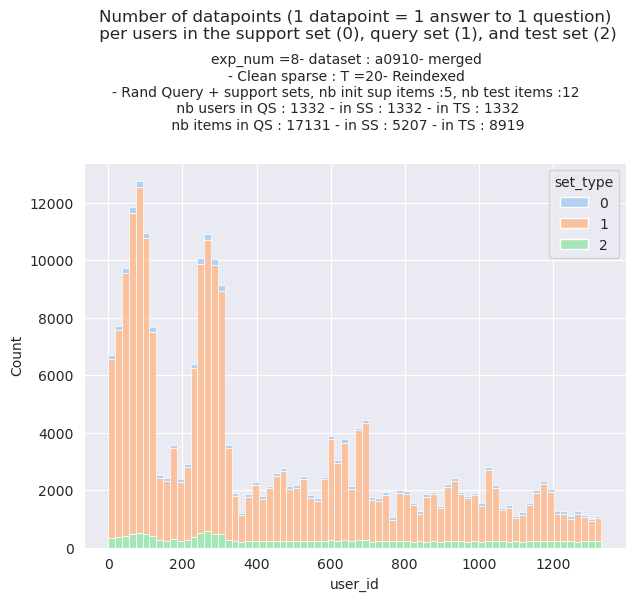

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt
f = plt.figure(figsize=(7,5))
#sns.axes_style("darkgrid")
ax = f.add_subplot(1,1,1)

plt.title("Number of datapoints (1 datapoint = 1 answer to 1 question)\n per users in the support set (0), query set (1), and test set (2)", fontsize=12, y=1.3)
plt.suptitle(metadata, y=1.1, fontsize=10)

sns.histplot(data=dataset, ax=ax, stat="count", multiple="stack",
             x="user_id", kde=False,
             palette="pastel", hue="set_type",
             element="bars", legend=True)

#sns.set(rc={'figure.facecolor':'#adadad'})
sns.axes_style("whitegrid")
plt.savefig(exp_path+"/hist_nb_record_per_users",
        dpi=None,
        facecolor='w',
        edgecolor='w',
        orientation='portrait',
        format=None,
        transparent=False,
        bbox_inches="tight",
        pad_inches=0.5,
        metadata=None)


In [41]:
dataset[dataset['user_id']==1128]

,user_id,item_id,score,set_type
65,1128,6319,1.0,1
1579,1128,6356,1.0,1
2892,1128,5324,0.0,1
6735,1128,9827,0.0,1
17622,1128,12420,1.0,1
23343,1128,5539,1.0,1
29197,1128,5532,0.0,1
37727,1128,5809,1.0,1
42921,1128,7561,0.0,1
48276,1128,7580,0.0,2


In [40]:
support_set[support_set['user_id']==1128]

,user_id,item_id,score,set_type


In [39]:
query_set['user_id'].unique()[52]

1128

In [42]:
np.isin(836,user_list)

array(True)

In [24]:
dataset['skill'].unique()

array(['properties-of-geometric-figures',
       'sum-of-interior-angles-more-than-3-sides', 'point-plotting',
       'transformations-rotations', 'reading-graph', 'area', 'perimeter',
       'square-root', 'isosceles-triangle',
       'application: isosceles triangle', 'multiplying-decimals',
       'proportion', 'pythagorean-theorem',
       'interpreting-linear-equations', 'pattern-finding',
       'application: compare points',
       'application: multi-column subtraction',
       'application: simple multiplication',
       'application: compare expressions',
       'application: order of operations',
       'application: multi-column addition', 'noskill',
       'application: read points', 'application: find slope in graph',
       'p-patterns-relations-algebra', 'percent-of', 'venn-diagram',
       'equivalent-fractions-decimals-percents', 'of-means-multiply',
       'fraction-multiplication', 'supplementary-angles', 'transversals',
       'triangle-inequality', 'multiplication

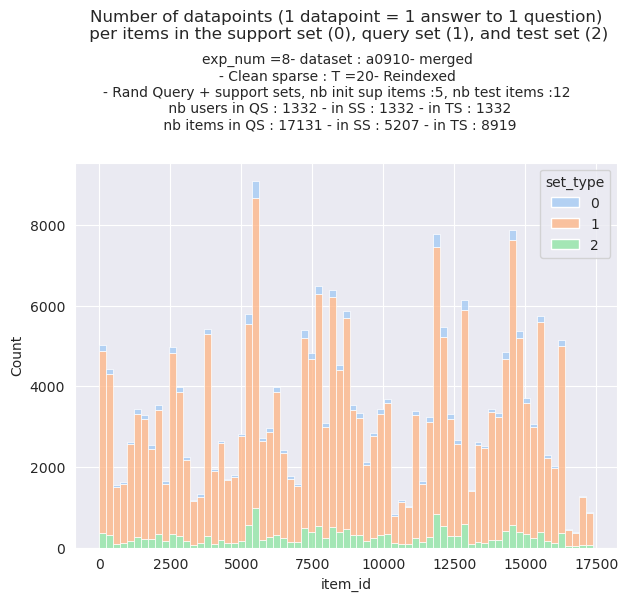

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt
f = plt.figure(figsize=(7,5))
ax = f.add_subplot(1,1,1)

plt.title("Number of datapoints (1 datapoint = 1 answer to 1 question)\n per items in the support set (0), query set (1), and test set (2)", fontsize=12, y=1.3)
plt.suptitle(metadata, y=1.1, fontsize=10)

sns.histplot(data=dataset, ax=ax, stat="count", multiple="stack",
             x="item_id", kde=False,
             palette="pastel", hue="set_type",
             element="bars", legend=True)

sns.axes_style("whitegrid")
plt.savefig(exp_path+"/hist_nb_record_per_items",
        dpi=None,
        facecolor='w',
        edgecolor='w',
        orientation='portrait',
        format=None,
        transparent=False,
        bbox_inches="tight",
        pad_inches=0.5,
        metadata=None)

In [96]:
# construction d'une matrice des scores du training set
R = -1 * np.ones(shape=(int(nb_users), int(nb_pb)))
R[support_set['user_id'], support_set['item_id']] = support_set['score']
print(R)

[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


## Training

In [97]:
import logging
import importlib

logging.getLogger().setLevel(logging.INFO)

#This module defines functions and classes which implement a flexible event logging system for applications and libraries.
import EduCDM

importlib.reload(EduCDM)
from EduCDM import EMIRT
dimension = 1
cdm = EMIRT(R, nb_users, nb_pb, dim=dimension, skip_value=-1)  # Attention, ici dim =1 !!

cdm.train(lr=1e-3, epoch=2)

Test de modification du codd ?


In [98]:
with open(exp_path+"/metadata", 'w') as f:
    f.write('CDM_dim = '+str(dimension))
#cdm.save("irt.params")

## Validation

### Bloc validation

In [99]:
test_set_list = []
for ind,row in test_set.iterrows() :
    test_set_list.append({'user_id':int(row['user_id'])-1, 'item_id':int(row['item_id'])-1, 'score':row['score']}) #TODO : verify if int important
#cdm.load("irt.params")
rmse, mae = cdm.eval(test_set_list)
print("RMSE, MAE are %.6f, %.6f" % (rmse, mae))

with open(exp_path+"/RPSE_MAE", 'w') as f:
    f.write('RMSE : '+str(rmse)+', MAE : '+str(mae))

evaluating: 100%|██████████| 19030/19030 [00:00<00:00, 2098971.92it/s]

RMSE, MAE are 0.546462, 0.438300


### Incremental validation

In [100]:
# Creation of incremental set
try :
    query_set.insert(0,'submission_order_per_user',[-1]*query_set.shape[0])
except ValueError as error :
    print("catch error "+str(error))

for user in query_set['user_id'].unique() :
    nb_items = query_set[query_set['user_id']==user].shape[0]
    order = np.arange(nb_items,dtype=int)
    np.random.shuffle(order)
    query_set.loc[query_set['user_id']==user,'submission_order_per_user'] = order

In [101]:
max_item_per_user = query_set['submission_order_per_user'].max()

loss = []

i=0
iteration_range = 1
start_indexes = [i]

while start_indexes[-1]+iteration_range <= max_item_per_user :
    items_to_submit = query_set[query_set['submission_order_per_user'].between(start_indexes[-1],start_indexes[-1]+iteration_range)]
    #items_to_test = query_set[query_set['submission_order_per_user'].between(start_indexes[-1]+iteration_range+1,max_item_per_user)]
    cdm.update(np.array(items_to_submit['user_id']),np.array(items_to_submit['item_id']),np.array(items_to_submit['score']),lr=1e-3, epoch=2)

    loss.append(cdm.cal_loss(test_set)[0])

    start_indexes.append(start_indexes[-1]+iteration_range)
    i+=1
    iteration_range = pow(2,(i//10))

iteration_range = (max_item_per_user-start_indexes[-1]) // 10
while start_indexes[-1]+iteration_range <= max_item_per_user :
    items_to_submit = query_set[query_set['submission_order_per_user'].between(start_indexes[-1],start_indexes[-1]+iteration_range)]
    #items_to_test = query_set[query_set['submission_order_per_user'].between(start_indexes[-1]+iteration_range+1,max_item_per_user)]
    cdm.update(np.array(items_to_submit['user_id']),np.array(items_to_submit['item_id']),np.array(items_to_submit['score']),lr=1e-3, epoch=2)

    loss.append(cdm.cal_loss(test_set)[0])

    start_indexes.append(start_indexes[-1]+iteration_range)


with open(exp_path+"/loss", 'w') as f:
    f.write('Indexes = '+str(start_indexes)+'\nMAE = '+str(loss))

In [45]:
with open(exp_path+"/loss", 'w') as f:
    f.write('Indexes = '+str(start_indexes)+'\nMAE = '+str(loss))

In [75]:
Indexes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 34, 38, 42, 46, 50, 54, 58, 62, 66, 70, 78, 86, 94, 102, 110, 118, 126, 134, 142, 150, 166, 182, 198, 214, 230, 246, 262, 278, 294, 310, 342, 374, 406, 438, 470, 502, 534, 566, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614]
MAE = [0.33071602288703567, 0.33124810756493656, 0.3333370139648748, 0.3402436182796575, 0.3376538699430213, 0.3395099798308957, 0.3371601867915728, 0.3355031313385574, 0.33719095475068467, 0.33704561672534755, 0.3364900182511194, 0.33978375400425903, 0.339160976417659, 0.3371853604324618, 0.3406797044182908, 0.3411532607870899, 0.3445063704157671, 0.3463866968206642, 0.3442612330078846, 0.3473509615193741, 0.3397751628925435, 0.34048048556318483, 0.34698012693224833, 0.3508390765914666, 0.34770157911401095, 0.34717173177471755, 0.3461510138398964, 0.3433397443051485, 0.3421725278319892, 0.3433744280599704, 0.34335957076081697, 0.348165473810884, 0.3463012012071567, 0.3435545776751405, 0.35050750894731103, 0.35278450073649437, 0.35421798947419625, 0.34958959463567213, 0.3493402704321161, 0.34928758037415497, 0.3504759189716379, 0.3494217554511806, 0.3581982258957496, 0.352938456447087, 0.3507932278144362, 0.3518149142223949, 0.3534858787882069, 0.3535036812582865, 0.35306771265585124, 0.35244557683453626, 0.35028668901259674, 0.34979275414395744, 0.3521607438999414, 0.352516056482005, 0.352074055315611, 0.350388825619918, 0.34944660108329084, 0.35139859037836557, 0.35338040010948785, 0.3557126615893804, 0.3522888472166088, 0.35301977093642156, 0.3557625254702259, 0.3589415793936745, 0.35542280852640956, 0.3521881496931281, 0.35465153301589913, 0.3549970266312621, 0.35656809102668136, 0.3607265947741442, 0.35959909129797, 0.3579204231889081, 0.35765146602333414, 0.3604905615279515, 0.3627468227114996]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


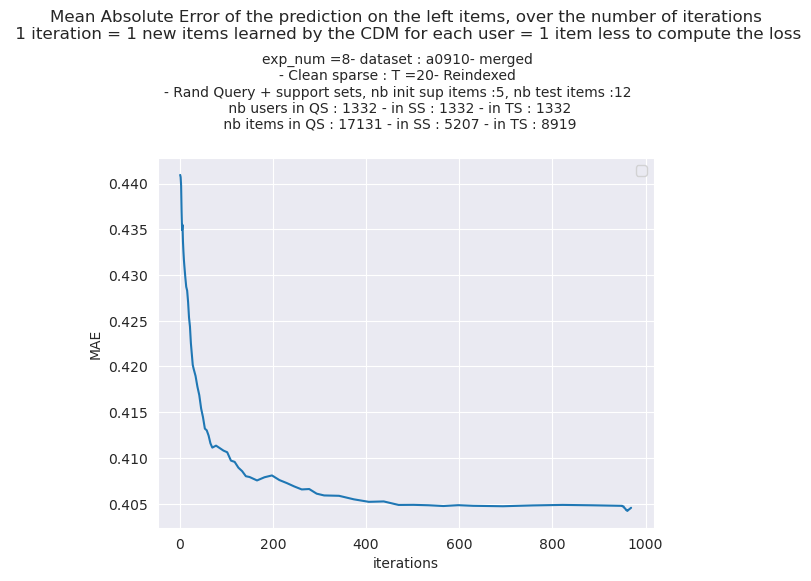

In [102]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots()

plt.title("Mean Absolute Error of the prediction on the left items, over the number of iterations\n 1 iteration = 1 new items learned by the CDM for each user = 1 item less to compute the loss", fontsize=12, y=1.3)
plt.suptitle(metadata, y=1.1, fontsize=10)
plt.xlabel('iterations')
plt.ylabel('MAE')
#ax.plot(Indexes[1:],MAE)
ax.plot(start_indexes[1:],loss)
plt.legend()
#ax.plot(start_indexes[1:],loss)

#experience_num = "4"
#exp_path = "/home/arthurb/Programmation/EduCDM/Experiences/"+experience_num
#try :
#    os.mkdir(exp_path)
#except OSError as error:
#    print(error)
plt.savefig(exp_path+"/loss_curve",dpi=None,orientation='portrait',format=None,transparent=False,bbox_inches="tight",pad_inches=1,metadata=None)

In [103]:
rmse_list = []
mae_list = []
loss = []

batch = categorized_validation_data['user_id'].unique() // 10
i=0

for user in categorized_validation_data['user_id'].unique() :
    for row in categorized_validation_data[categorized_validation_data['user_id']==user][['set_type','item_id','score']].iterrows() :
        if row[1]['set_type']==0 :
            cdm.update(user,int(row[1]['item_id']), int(row[1]['score']),lr=1,epoch=1)
    i +=1
    if i%batch ==0 :
        rmse, mae = cdm.eval(test_set)
        rmse_list.append(rmse)
        mae_list.append(mae)

evaluating: 100%|██████████| 90936/90936 [00:00<00:00, 911052.95it/s]


KeyboardInterrupt: 

In [104]:
print(rmse_list)

[0.5721066960881296, 0.5721067849113305, 0.5719684874444605, 0.5716218865832735, 0.5715844129871276, 0.5715179811726908, 0.5712062787440857, 0.5702770024396718, 0.5702765703452379, 0.5700202745221493, 0.569862941784808, 0.5697573177040467, 0.5697563180812933, 0.5693166494148763, 0.5693167043625086, 0.569316749377926, 0.5693167882126391, 0.5693168223567787, 0.5692780785000512, 0.5692781067444828, 0.5692781310241647, 0.5692482792525733, 0.5692483011962027, 0.5692483186942557, 0.5691340710882897, 0.5691271750095775, 0.5688555329160563, 0.5685227035414706, 0.5685248634088128, 0.568423509051033, 0.5681852775086154, 0.5681852859226075, 0.5671910005012518, 0.5671707162292504, 0.5671707246467965, 0.5671707300017541, 0.5671707348480063, 0.5671707393712543, 0.5671707436342026, 0.5671707476726116, 0.5671707515111956, 0.5669032170598974, 0.5659256016817087, 0.5659002958440076, 0.5659003017525303, 0.565900304851634, 0.564818232826464, 0.5648182367349013, 0.5646636810136874, 0.5646636892013224, 0.56

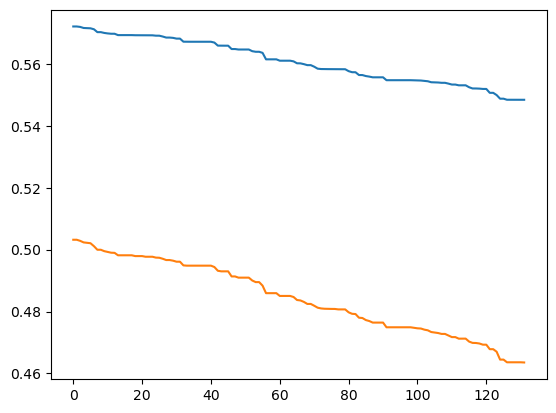

In [107]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots()

ax.plot(range(len(rmse_list)),rmse_list)
ax.plot(range(len(mae_list)),mae_list)

plt.show()

In [73]:
rmse_list

[nan]

[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100]